# **Text Representation aka Text Embeddings**
Text embeddings are a way to represent words or phrases as vectors in a high-dimensional space based on their contextual meaning within a corpus of text data. The idea is that if two phrases are similar then the vectors that represent those phrases should be close together and vice versa.

### **What's Covered**
1. Introduction to Feature Extraction
2. Case Study - Identifying Relavant US Economy News Articles
3. Various Feature Representation Techniques
    - Basic Vectorization Approaches
    - Distributed Representation
    - Universal Language Representation
    - Handcrafted Features
4. What is Language Modeling?
5. Use Cases
6. Some Real Time Applications

## **Introduction to Feature Extraction**
1. Feature Extraction is an important step for any machine learning problem.
2. No matter how good a modeling algorithm you use, if you feed in poor features, you will get poor results.
3. **Remember:** "Garbage in, garbage out."
4. Data can be text, images, videos, or speech.
5. Mathematically representing images, videos and speech is straightforward.
6. However, feature representation for text is often much more involved as compared to other formats of data.

**Let's learn the importance of text representation by solving an example.**

## **Case Study - Identifying Relavant US Economy News Articles**

The dataset below consists of 8000 news articles annotated with whether or not they're relavant to US economy (i.e., a yes/no binary classification). The dataset is known to be imbalanced.

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("data/full_economic_news_articles.csv", encoding="latin1")

df.head()

,relevance,articleid,date,headline,text
0,yes,wsj_398217788,8/14/91,Yields on CDs Fell in the Latest Week,NEW YORK -- Yields on most certificates of dep...
1,no,wsj_399019502,8/21/07,The Morning Brief: White House Seeks to Limit ...,The Wall Street Journal Online</br></br>The Mo...
2,no,wsj_398284048,11/14/91,Banking Bill Negotiators Set Compromise --- Pl...,WASHINGTON -- In an effort to achieve banking ...
3,no,wsj_397959018,6/16/86,Manager's Journal: Sniffing Out Drug Abusers I...,The statistics on the enormous costs of employ...
4,yes,wsj_398838054,10-04-2002,Currency Trading: Dollar Remains in Tight Rang...,NEW YORK -- Indecision marked the dollar's ton...


In [3]:
df.shape

(8000, 5)

In [10]:
from wordcloud import WordCloud

wc = WordCloud(background_color='black',
               width=1600,
               height=800).generate(' '.join(df['text']))

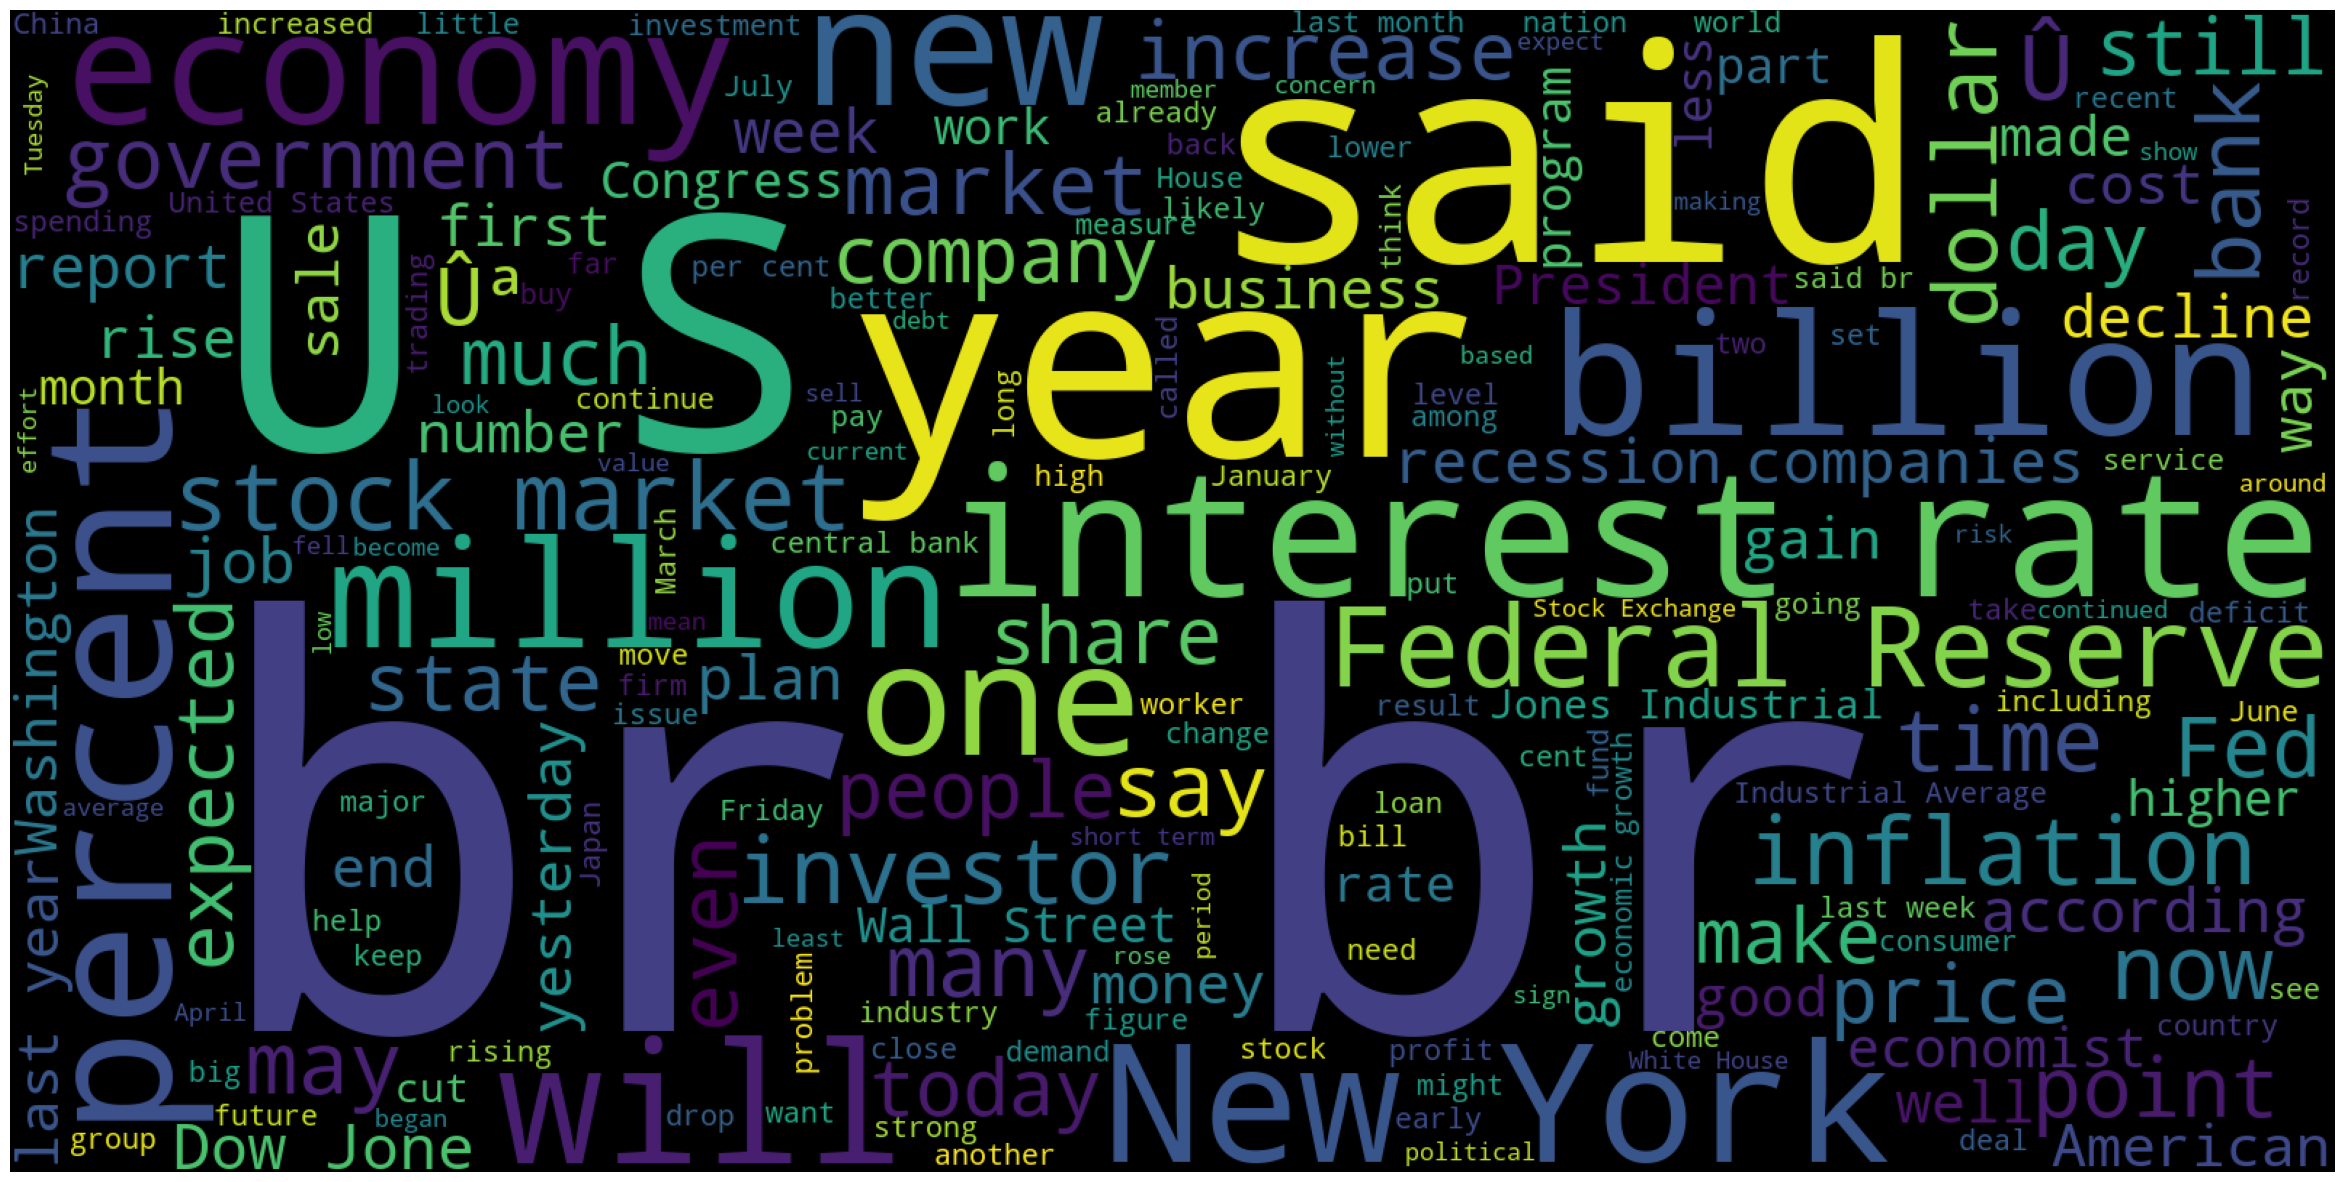

In [11]:
import matplotlib.pyplot as plt

plt.figure(1,figsize=(30,20))
plt.imshow(wc)
plt.axis('off')
plt.show()

In [4]:
df['relevance'].value_counts(normalize=True)

relevance
no          0.821375
yes         0.177500
not sure    0.001125
Name: proportion, dtype: float64

There is an imbalance in the data with **not relevant** being 82% in the dataset. That is, most of the articles are not relevant to US Economy, which makes sense in a real-world scenario, as news articles discuss various topics. We should keep this class imbalance mind when interpreting the classifier performance later. Let us first convert the class labels into binary outcome variables for convenience. 1 for Yes (relevant), and 0 for No (not relevant), and ignore "Not sure".

In [5]:
# removing the data where we don't want relevance="not sure".
df = df[df.relevance != "not sure"]

df.shape

(7991, 5)

In [6]:
# convert label to a numerical variable
df['relevance'] = df.relevance.map({'yes':1, 'no':0}) # relevant is 1, not-relevant is 0. 

# Let us take only the two columns we need
df = df[["text", "relevance"]] 
df.shape

(7991, 2)

In [7]:
# Step 1: Identify Input and Output

from sklearn.model_selection import train_test_split

X = df.text # the column text contains textual data to extract features from
y = df.relevance # this is the column we are learning to predict. 
print(X.shape, y.shape)

(7991,) (7991,)


In [8]:
# Step 2: Split the data into train and test

# split X and y into training and testing sets. 
# By default, it splits 75% training and 25% test
# random_state=1 for reproducibility

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(5993,) (5993,)
(1998,) (1998,)


In [12]:
# Step 3: Data Preprocessing on train data (X_train)

import string

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Initialize WordNet lemmatizer
lemmatizer = WordNetLemmatizer()

In [13]:
# nltk.download('wordnet')

In [16]:
def clean(doc): # doc is a string of text
    # This text contains a lot of <br/> tags.
    doc = doc.replace("</br>", " ")
    
    # Remove punctuation and numbers.
    doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])
    
    # Tokenization
    tokens = nltk.word_tokenize(doc)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Stop word removal
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in lemmatized_tokens if word.lower() not in stop_words]
    
    # Join and return
    return " ".join(filtered_tokens)

In [17]:
# import feature extraction methods from sklearn
from sklearn.feature_extraction.text import CountVectorizer

# instantiate a vectoriezer
vect = CountVectorizer(preprocessor=clean)

# use it to extract features from training data
X_train_dtm = vect.fit_transform(X_train)

print(X_train_dtm.shape)

(5993, 46560)


In [20]:
# Step 4: Data Preprocessing on test data (X_test)

# transform testing data (using training data's features)
X_test_dtm = vect.transform(X_test)

print(X_test_dtm.shape)

(1998, 46560)


In [21]:
# Step 5: Building a Model (i.e. Train the classifier)

# import classifiers from sklearn
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB() # instantiate a Multinomial Naive Bayes model
%time nb.fit(X_train_dtm, y_train) # train the model(timing it with an IPython "magic command")

CPU times: total: 15.6 ms
Wall time: 8.92 ms


MultinomialNB()

In [23]:
# Step 6: Evaluate on train data

from sklearn import metrics
# make class predictions for X_train_dtm
y_train_pred = nb.predict(X_train_dtm)

metrics.confusion_matrix(y_train, y_train_pred)

array([[4209,  706],
       [ 250,  828]], dtype=int64)

Text(0.5, 23.52222222222222, 'Predicted')

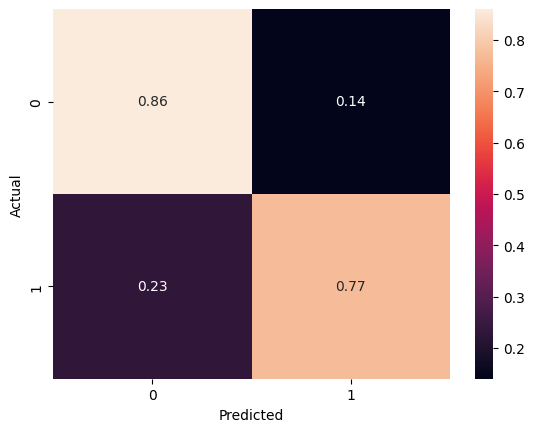

In [25]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

cm = metrics.confusion_matrix(y_train, y_train_pred)
actual = np.sum(cm, axis=1).reshape(-1, 1)
cmn = np.round(cm/actual, 2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=nb.classes_, yticklabels=nb.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [26]:
# Step 7: Evaluate on test data

# make class predictions for X_test_dtm
y_test_pred = nb.predict(X_test_dtm)

metrics.confusion_matrix(y_test, y_test_pred)

array([[1404,  252],
       [ 198,  144]], dtype=int64)

Text(0.5, 23.52222222222222, 'Predicted')

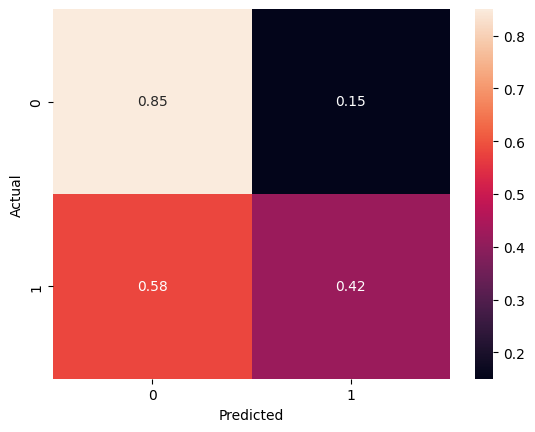

In [27]:
cm = metrics.confusion_matrix(y_test, y_test_pred)
actual = np.sum(cm, axis=1).reshape(-1, 1)
cmn = np.round(cm/actual, 2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=nb.classes_, yticklabels=nb.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')

At this point, we can notice that the classifier is doing poorly with identifying relevant articles, while it is doing well with non-relevant ones. 

**Potential Reasons for poor classifier performance**
1. Perhaps we need to balance the data - Clearly there is class imbalance
2. Perhaps we need a better learning algorithm - Implement Logistic Regression, SVM, RF, etc...
3. Perhaps we should look for tuning the classifier's parameter with the help of Hyperparameter Tuning
4. Perhaps we need a better pre-processing and feature extraction mechanism - Right now we have a sparse and large feature vector

**Let's work with potential reason number 4.**  
Our large feature vector could be creating a lot of noise in the form of very rarely occurring features that are not useful for learning. Let us change the count vectorizer to take a certain number of features as maximum.

In [34]:
vect = CountVectorizer(preprocessor=clean, max_features=5000) # instantiate a vectoriezer
X_train_dtm = vect.fit_transform(X_train) # use it to extract features from training data

# transform testing data (using training data's features)
X_test_dtm = vect.transform(X_test)
print(X_train_dtm.shape, X_test_dtm.shape)

(5993, 5000) (1998, 5000)


In [35]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB() # instantiate a Multinomial Naive Bayes model
%time nb.fit(X_train_dtm, y_train) # train the model(timing it with an IPython "magic command")
y_test_pred = nb.predict(X_test_dtm) # make class predictions for X_test_dtm

CPU times: total: 0 ns
Wall time: 4.99 ms


Text(0.5, 23.52222222222222, 'Predicted')

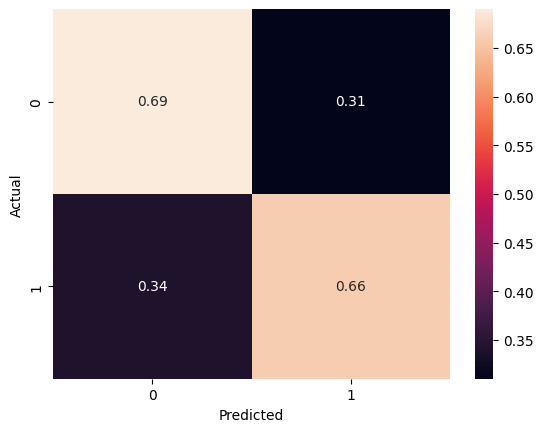

In [36]:
cm = metrics.confusion_matrix(y_test, y_test_pred)
actual = np.sum(cm, axis=1).reshape(-1, 1)
cmn = np.round(cm/actual, 2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=nb.classes_, yticklabels=nb.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')

Clearly, the performance on relevance classification got better.

Now, you can consider **trying a better feature representation technique for text data.** I have mentioned various feature representation techniques below. 

## **Various Feature Representation Techniques**

Feature representation for text are classified into four categories:  
- **Basic Vectorization Approaches**
   - Eg: One-Hot Encoding, Bag of Words, Bag of N-Grams, and TFIDF
   - Drawbacks: They are discrete representations, vector representation is sparse and hig-dimensional, and they cannot handle OOV words.
- **Distributed Representations**
   - Eg: Word Embeddings (Word2Vec, GloVe, fastText), Document Embeddings (Doc2Vec)
   - Text embeddings are a way to represent words or phrases as vectors in a high-dimensional space based on their contextual meaning within a corpus of text data. The idea is that if two phrases are similar then the vectors that represent those phrases should be close together and vice versa.
   - Word2Vec Arcitecture - Continuous Bag of Words (CBOW) and SkipGram
   - Word2Vec don't have a good way of handling OOV words
   - **Handling OOV words problem:** One way is by modifying the training process by bringing in characters and other sub-level linguistic components such as morphological properties (e.g., prefixes, suffixes, word endings, etc...). **FastText** from facebook follows this approach.
   - Drawbacks: Above techniques only provide word embeddings. Inorder to get document embedding, we can aggregate the word embeddings to get document embeddings. But, for sentences "dog bites man" and "man bites dog", both will receive same representation.
   - Doc2Vec: Based on Paragraph vector framework. Neural network used to learn Doc2Vec embeddings is very similar to CBOW and SkipGram architecture of Word2Vec.
   - Doc2Vec Architecture - Distributed Memory (DM) and Distributed Bag of Words (DBOW)
- **Universal Language Representaion**
   - Problem in all the above approaches: One word gets one fixed representation
   - Eg: "I went to bank to withdraw money" and "I sat on the river bank" both uses the word "bank"
   - In 2018 - Researchers came with **Contextual Word Representations**, which addresses the above problem
   - **Remember:** Recently, Contextual Word Representations are learned by using the word embeddings we discussed earlier (like Word2Vec) and training on **language modeling** task using complex neural architecture (like RNNs and Transformers).
   - **Language Modeling:** It is a task of predicting the next likely word in a sequence of words. In its earliest form, it used the idea of n-gram frequencies to estimate the probability of the next word given a history of words.
   - **Key Idea:** Learn embedding on a generic task like language modeling on a massive corpus and then fine-tune learnings on a task-specific data. This is also known as **transfer learning**.
   - **How to decide whether to train our own embeddings or use pre-trained embeddings?** - A good rule of thumb is to compute the vocabulary overlap. If the overlap between the vocabulary of our custom domain and that of pre-trained word embeddings is significant, pre-trained word embeddings tends to give good results.
   - **One more important factor to consider while deploying models with embeddings-based feature extraction approach:** - Remember that learned or pre-trained embedding models have to be stored and loaded into memory while using these approaches. If the model itself is bulky, we need to factor this into our deployment needs.
- **Handcrafted Features**
   - These features have to be designed manually, keeping in mind both the domain knowledge and the ML algorithms to train the NLP models.
   - Custom feature engineering is much more difficult to formulate compared to other feature engineering schemes we've seen so far.  


## **What is Language Modeling?**
1. Language Modeling involves creation of statistical/deep learning models for predicting the likelyhood of a sequence of tokens in a specified vocabulary.
2. Two types of Language Modeling Tasks are:  
    a. Autoencoding Task  
    b. Autoregressive Task  
3. **Autoregressive Language Models** are trained to predict the next token in a sentence, based on the previous tokens in the phrase. These models correspond to the **decoder** part of the transformer model. A mask is applied on the full sentence so that the attention head can only see the tokens that came before. These models are ideal for text generatation. For eg: **GPT**
4. **Autoencoding Language Models** are trained to reconstruct the original sentence from a corrupted version of the input. These models correspond to the **encoder** part of the transformer model. Full input is passed. No mask is applied. Autoencoding models create a bidirectional representation of the whole sentence. They can be fine-tuned for a variety of tasks, but their main application is sentence classification or token classification. For eg: **BERT**
5. **Combination of autoregressive and autoencoding language models** are more versatile and flexible in generating text. It has been shown that the combination models can generate more diverse and creative text in different context compared to pure decode-based autoregressive models due to their ability to capture additional context using the encoder. For eg: **T5**


## **Some Real Time Applications**
- Content Classification and Organisation
    - Tagging product description in an e-commerce website
    - Language Identification
    - Segregating fake news from real news
    - Identifying the unknown authors of texts from a pool of authors - Also used in Forensic Analysis
    - Organizing emails into personal, social and promotions in Gmail
    - Use case for news website, blogs, online nookshelves, product reviews, tweets, etc...
- Customer Support
    - Text classification is often used to identify the tweets that brands must respond to and those that don't require a response.
    - Routing customer service request in a company to the appropriate support team
    - Chat assistants or Virtual assistants
- Ecommerce
    - Understand and analyze customers perception of a product or service based on their comments (i.e. Sentiment Analysis)
- Social Media
    - Sentiment Analysis
    - Rumor/Fake News Detection
    - Adult Content Filtering
    - Trending topic detection
    - Opinion Mining

## **Use Cases**
1. Text Classification
    - Sentiment Analysis, Spam Ham Detection, Fake news detection, Adult content filtering, etc...
    - **Pipeline without learning** - Given a corpus of tweets where each tweet is labeled with its corresponding sentiment - negative and positive. We want to build a classification system that will predict the sentiment of an unseen tweet using only text of the tweet. A simple solution could be to create a list of positive and negative words in english. Now compute the useage of positive versus negative words in the input tweet and make a prediction based on the information. Further enhancements to this approach may involve creating more sophisticated dictionaries with degrees of positive, negative and neutral sentiment of words or formulating specific heuristics (e.g., useage of certain smileys indicate positive sentiment) and using them to make predictions. This approach is called `lexicon-based sentiment analysis`.
    - Pipeline with ML/DL Approaches
2. Information Extraction
    - Keyphrase Extraction: Extraction of bunch of commonly used keywords or phrases from the text data.
    - Named Entity Recognition: Task of Identifying the entities in a document. Entities are typically name of person, location and organizations. It can also be dates, products, names/numbers of laws or article, etc...
    - Quick Note: POS Tagging can improve the NER performance.
    - NER is not a normal classification task. It is modeled as a sequence classification problem, because if you think about it entity prediction for the current word also depends on the context.
    - To illustrate the difference between a normal classifier and a sequence classifier, conside the following sentence: "Washington is a rainy state." When a normal classifier sees this sentence and has to classify it word by word, it has to make a decision as to whether Washington refers to a person or the State, without looking at the surroundeing words. Conditional Random Fields (CRFs) were classical popular sequence classifier training algorithms. Now a days, there are RNNs, LSTMs, Transformers, etc that can generate state-of-the-art results.
    - Named Entity Disambiguation (NED) and Linking (NEL), Relationship Extraction, etc...: Use Azure or Google API
3. Search and Information Retrieval
4. Chatbot
5. Topic Modeling and Summarization
    - Let's say there is a big law firm client. Whenever a new case comes up, they sometimes have to research lots and lots of documents related to the case to get a bigger picture of what its about. Sometimes there isn't enough time for a thorugh manual review. Our client wants us to develop software that can provide a quick overview of the topics discussed in large collection of documents. Topic modeling is a technique thats used to address this problem of finding latent topics in a large collection of documents.
    - The same client has another problem: Case report document they receive are usually quiet long, and it's difficult even for an experienced lawyer to get the gist quickly. So our client wants a solution to automatically create summaries of text documents. Text summarization approaches are used to address such use cases in the industry.
6. Text Generation
7. Machine Translation
8. Question and Answering